# Explore the dataset Reviews

In [28]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

Customs util funtions 

In [3]:
import utils as u
from importlib import reload as reload
reload(u)
help(u)


Help on module utils:

NAME
    utils

FUNCTIONS
    clean_and_tokenize(text)
    
    count_words(texts, voc=None)
    
    tfidf_transform(bow)

FILE
    d:\work\telecom paris\kit big data\project\mangetamain_17_10\mangetamain\utils.py




##### Load the datasets

In [4]:
interactions_df = pd.read_csv('data/raw/RAW_interactions.csv' )
recipes_df      = pd.read_csv('./data/raw/RAW_recipes.csv')

In [5]:
interactions_df.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


Check if the interactions dataset has empty values in user_id, recipe_id or rating columns

In [ ]:
empty_lines_interactions = interactions_df[['user_id', 'recipe_id', 'rating']].isna().any(axis=1)
print(f"Number of empty lines in interactions dataset: {empty_lines_interactions.sum()}")


Number of empty lines in interactions dataset: 0


In [ ]:
recipes_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


Check if the interactions dataset has empty values in id or contributor_id columns

In [8]:
empty_lines_recipes = recipes_df[['id', 'contributor_id']].isna().any(axis=1)
print(f"Number of empty lines in recipes dataset: {empty_lines_recipes.sum()}")

Number of empty lines in recipes dataset: 0


# I Basic Stats

### Distributions of the ratings

<Axes: >

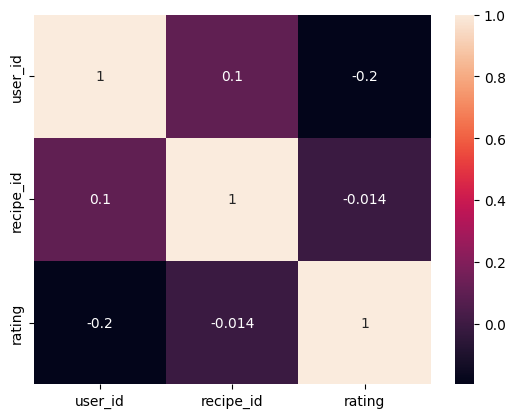

In [39]:
sns.heatmap(interactions_df[['user_id', 'recipe_id', 'rating']].astype(float).corr(), annot=True)

We can see that the correlations between user_id, recipe_id and rating are very low. This means that there is no strong relationship between the user and the rating they give, or the recipe and the rating it receives.

In [15]:
mean_ratings_user_id = interactions_df.groupby('user_id')['rating'].mean().reset_index()
mean_ratings_user_id = mean_ratings_user_id.rename(columns={'rating': 'mean_rating'})
mean_ratings_user_id.head()

,user_id,mean_rating
0,1533,4.710938
1,1535,4.473552
2,1581,5.000000
3,1634,3.616667
4,1676,4.677419


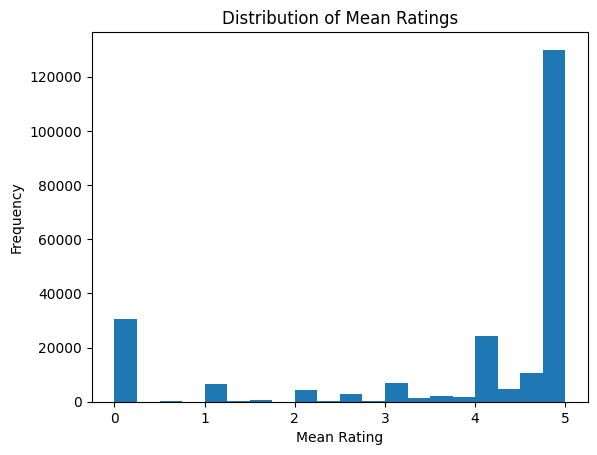

In [20]:
plt.hist(mean_ratings_user_id['mean_rating'], bins=20)
plt.title('Distribution of Mean Ratings')
plt.xlabel('Mean Rating')
plt.ylabel('Frequency')
plt.show()

#### We can see that the ratings are either very high or very low (Not a gaussian distribution). Most of the users give high ratings.

In [21]:
mean_ratings_recipe_id = interactions_df.groupby('recipe_id')['rating'].mean().reset_index()
mean_ratings_recipe_id = mean_ratings_recipe_id.rename(columns={'rating': 'mean_rating'})
mean_ratings_recipe_id.head()

,recipe_id,mean_rating
0,38,4.250000
1,39,3.000000
2,40,4.333333
3,41,4.500000
4,43,1.000000


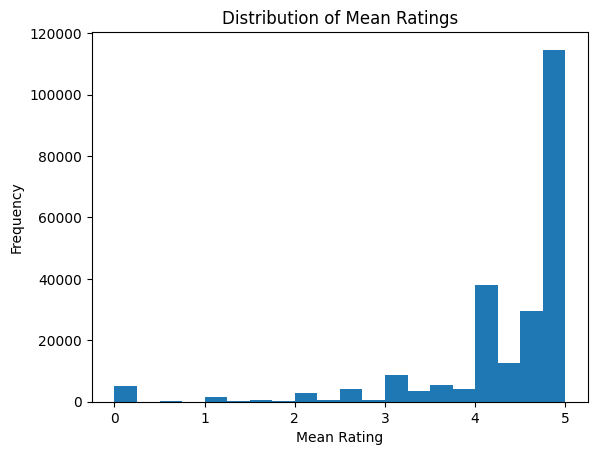

In [22]:
plt.hist(mean_ratings_recipe_id['mean_rating'], bins=20)
plt.title('Distribution of Mean Ratings')
plt.xlabel('Mean Rating')
plt.ylabel('Frequency')
plt.show()

On peut observer que la plupart des utilisateurs donnent des notes élevées, tandis que quelques-uns donnent des notes très basses. De même, la majorité des recettes ont des notes moyennes élevées.

In [ ]:
z = (mean_ratings_recipe_id['mean_rating'] - mean_ratings_recipe_id['mean_rating'].mean()) / mean_ratings_recipe_id['mean_rating'].std(ddof=1)

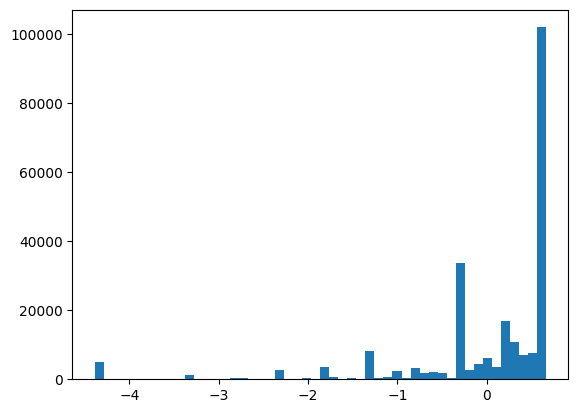

In [26]:
plt.hist(z, bins=50)
plt.show()

# II Link between the recipes and their reviews

The reviews had some empty values that we have to drop before processing them.

In [6]:
reviews_l = interactions_df['review'].to_list()
clean_interactions_df = interactions_df[['rating','review']].dropna()
print(f'Number of reviews before cleaning: {len(reviews_l)}')
print(f'Number of reviews after cleaning: {len(clean_interactions_df)}')
print(f'Printing the first 5 cleaned reviews:\n{clean_interactions_df["review"].head()}')

Number of reviews before cleaning: 1132367
Number of reviews after cleaning: 1132198
Printing the first 5 cleaned reviews:
0    Great with a salad. Cooked on top of stove for...
1    So simple, so delicious! Great for chilly fall...
2    This worked very well and is EASY.  I used not...
3    I made the Mexican topping and took it to bunk...
4    Made the cheddar bacon topping, adding a sprin...
Name: review, dtype: object


In [ ]:
clean_interactions_list = clean_interactions_df['review'].to_list()
print(f'Printing the first 5 cleaned reviews:\n{clean_interactions_list[:5]}')

Printing the first 5 cleaned reviews:
['Great with a salad. Cooked on top of stove for 15 minutes.Added a shake of cayenne and a pinch of salt.  Used low fat sour cream.  Thanks.', "So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Second time around, forgot the remaining cumin. We usually love cumin, but didn't notice the missing 1/2 teaspoon!", 'This worked very well and is EASY.  I used not quite a whole package (10oz) of white chips.  Great!', 'I made the Mexican topping and took it to bunko.  Everyone loved it.', 'Made the cheddar bacon topping, adding a sprinkling of black pepper. Yum!']


### We will try to find if there are any correlations between the ratings and the words used in the reviews.

In [21]:
vocab_reviews, vectorized_reviews = u.count_words(clean_interactions_list[:10000])
open('data/processed/vocab_reviews.txt', 'w').write('\n'.join(vocab_reviews))
np.save('data/processed/vectorized_reviews.npy', vectorized_reviews)

Vocab Update : Processing document 0/10000
Vocab Update : Processing document 1000/10000
Vocab Update : Processing document 2000/10000
Vocab Update : Processing document 3000/10000
Vocab Update : Processing document 4000/10000
Vocab Update : Processing document 5000/10000
Vocab Update : Processing document 6000/10000
Vocab Update : Processing document 7000/10000
Vocab Update : Processing document 8000/10000
Vocab Update : Processing document 9000/10000
Count Vectorization : Processing document 0/10000
Count Vectorization : Processing document 1000/10000
Count Vectorization : Processing document 2000/10000
Count Vectorization : Processing document 3000/10000
Count Vectorization : Processing document 4000/10000
Count Vectorization : Processing document 5000/10000
Count Vectorization : Processing document 6000/10000
Count Vectorization : Processing document 7000/10000
Count Vectorization : Processing document 8000/10000
Count Vectorization : Processing document 9000/10000


UnicodeEncodeError: 'charmap' codec can't encode characters in position 66539-66540: character maps to <undefined>

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()   # or pre-tokenize & use analyzer='word'
vectorized_reviews = cv.fit_transform(clean_interactions_list)  # sparse CSR matrix
vocab_reviews = cv.vocabulary_


In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tfidf_reviews = tfidf_transformer.fit_transform(vectorized_reviews)